In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from classical_code import *
from quantum_code import *
import stim
from scipy.sparse import lil_matrix
import scipy as sp
from ldpc import bposd_decoder, bp_decoder
from tqdm import tqdm
from result_lifetime import Result, save_new_res
# %load_ext snakeviz

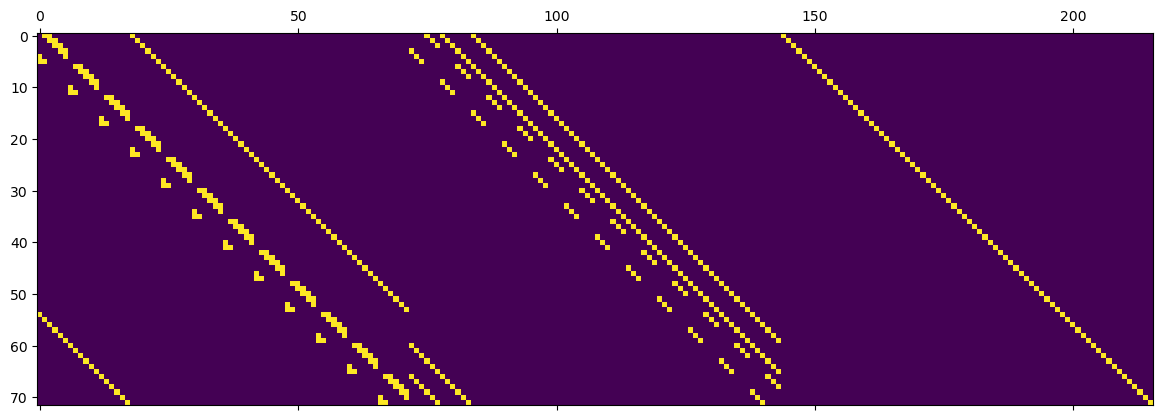

In [380]:
qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_100_4.qcode")
qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_C642_150_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_C422_200_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_C422_400_8.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_C642_600_16.qcode")

# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_400_16.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_C642_600_16.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_C422_800_16.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_C422_1600_32.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_C642_2400_64.qcode")

# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_900_36.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_C642_1350_36.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_C422_1800_36.qcode")

# qcode = read_qcode("../codes/qcodes/HGP_1600_64/HGP_1600_64.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C642_2400_64.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C422_3200_64.qcode")

qcode = read_qcode("../codes/qcodes/BB_72_12.qcode")
# qcode = read_qcode("../codes/qcodes/BB_C422_288_24.qcode")
# qcode = read_qcode("../codes/qcodes/BB_C422_144_12.qcode")


# qcode = read_qcode("../codes/qcodes/BB_108_8.qcode")
# qcode = read_qcode("../codes/qcodes/BB_C642_162_8.qcode")

qcode = read_qcode("../codes/qcodes/BB_144_12.qcode")
# qcode = read_qcode("../codes/qcodes/BB_C422_288_12.qcode")

# qcode = read_qcode("../codes/qcodes/BB_C422_576_24.qcode")


# concatenate_iceberg(qcode, 6, "../codes/qcodes/")
# concatenate_iceberg(qcode, 4, "../codes/qcodes/")
# concatenate_iceberg2(qcode, 6, "../codes/qcodes/")
# concatenate_iceberg2(qcode, 4, "../codes/qcodes/")



Hx, Hz, Lx, Lz = qcode.to_numpy()

aug_Hx = np.hstack([Hx, np.eye(Hx.shape[0], dtype=int)])
aug_Hz = np.hstack([Hz, np.eye(Hz.shape[0], dtype=int)])


qubit_error_rate = 0.03
meas_error_rate = 0.03

stab_type = True
tanner = True if meas_error_rate else False

H = Hx if stab_type else Hz
if tanner:
    dec_H = aug_Hx if stab_type else aug_Hz
    channel_probs = [qubit_error_rate]*H.shape[1] + [meas_error_rate]*H.shape[0]
else:
    dec_H = H
    channel_probs = [qubit_error_rate]*H.shape[1]
L = Lx if stab_type else Lz

plt.matshow(dec_H)


In [381]:
overlapping_x_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedxm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedxm,qcode.xm):
        if np.any(Hx[i] & Hx[j]): tmp = np.append(tmp, j)
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedzm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedzm,qcode.zm):
        if np.any(Hz[i] & Hz[j]): tmp = np.append(tmp, j)
    overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False, not_overlapping=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])

    if not_overlapping:
        return np.array(list(set(np.arange(qcode.qedxm,qcode.xm)) ^ gens_to_measure))
    else:
        return np.array(list(gens_to_measure))

In [382]:
if (qcode.qedzm):
    bp_qed_dec = bp_decoder(
        dec_H[:qcode.qedzm], # the parity check matrix
        # error_rate=qubit_error_rate,
        channel_probs=channel_probs,
        max_iter=10,
        bp_method="msl",
        ms_scaling_factor=0,
        # osd_method="osd0",
        # osd_order=40
    )

bposd_qed_qec_dec = bposd_decoder(
    dec_H,
    # error_rate=qubit_error_rate,
    channel_probs=channel_probs,
    bp_method="msl",
    max_iter=H.shape[1],
    ms_scaling_factor=0,
    osd_method="osd0",
    # osd_order=40 #the osd search depth
)

bposd_qec_dec = bposd_decoder(
    dec_H,
    # error_rate=qubit_error_rate,
    channel_probs=channel_probs,
    bp_method="msl",
    max_iter=H.shape[1],
    ms_scaling_factor=0,
    osd_method="osd0",
    # osd_order=4 #the osd search depth
)

def decode(curr_synd, concat, adaptive):
    guessed_error = np.zeros(H.shape[1], dtype=int)
    updated_synd = curr_synd.copy()
    non_overlapping_gens = get_overlapping(curr_synd[:qcode.qedzm], True, True)
    if (len(non_overlapping_gens)):
        updated_synd[non_overlapping_gens] = 0

    if (concat == 0):
        # QEC only
        if (adaptive == 1):
            guessed_error = bposd_qec_dec.decode(updated_synd)
        else:
            guessed_error = bposd_qec_dec.decode(curr_synd)
    elif (concat == 1):
        # QED + QEC
        _ = bp_qed_dec.decode(curr_synd[:qcode.qedzm])

        ######################## # THIS MIGHT NEED TO CHANGE SLIGHTLY, SOFT INFORMATION DECODING
        # new_channel_probs = np.exp(-bp_qed_dec.log_prob_ratios)
        new_channel_probs = 1 / (np.exp(bp_qed_dec.log_prob_ratios) + 1)
        new_channel_probs[H.shape[1]:] = meas_error_rate
        new_channel_probs = new_channel_probs / np.sum(new_channel_probs) /100

        bposd_qed_qec_dec.update_channel_probs(new_channel_probs)
        ########################

        if (adaptive == 1):
            guessed_error = bposd_qed_qec_dec.decode(updated_synd)
        else:
            guessed_error = bposd_qed_qec_dec.decode(curr_synd)

    return guessed_error

In [383]:
# np.random.seed(0)

num_iters = 1000
concat = 1 if qcode.qedxm else 0
# concat = 0
adaptive = 0
successes = 0

qubit_errors = []
synd_errors = []
synd = []

for ii in tqdm(range(1,num_iters+1)):
    curr_qubit_error = np.zeros(H.shape[1], dtype=int)

    success = 1
    for jj in range(1):
        new_qubit_error = np.random.choice([0, 1], size=H.shape[1], p=[1-qubit_error_rate, qubit_error_rate])
        new_synd_error = np.random.choice([0, 1], size=H.shape[0], p=[1-meas_error_rate, meas_error_rate])
        curr_qubit_error ^= new_qubit_error

        curr_synd = ((H @ curr_qubit_error) % 2) ^ new_synd_error
        guessed_error = decode(curr_synd, concat, adaptive)
        curr_qubit_error ^= guessed_error[:H.shape[1]]

    curr_synd = ((H @ curr_qubit_error) % 2)
    guessed_error = decode(curr_synd, concat, 0)
    curr_qubit_error ^= guessed_error[:H.shape[1]]
    # curr_synd = ((H @ curr_qubit_error) % 2)

    obs = (L @ curr_qubit_error) % 2

    if np.any(obs):
        success = 0
        qubit_errors.append(np.where(new_qubit_error)[0])
        synd_errors.append(np.where(new_synd_error)[0])


    successes += success

print()
print(1-successes/num_iters)

100%|██████████| 1000/1000 [00:00<00:00, 1900.19it/s]


0.08399999999999996


[ 4 25 37 50 52 59 60 61 63 64 68 69 74 84 85 90 93]
[ 17 103 150 252 260 268 269 284 285 293]


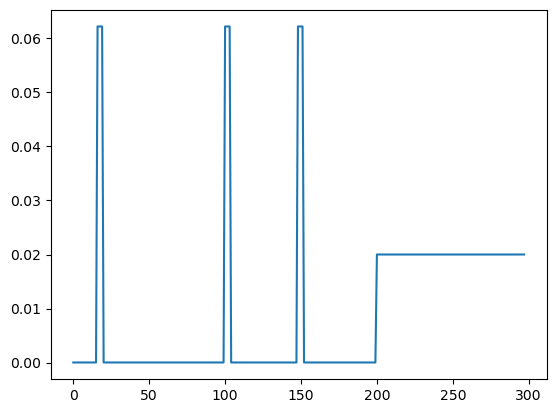

In [262]:
curr_qubit_error = np.zeros(H.shape[1], dtype=int)
new_qubit_error = np.zeros(H.shape[1], dtype=int)
new_qubit_error[np.array([17,  52,  54, 100, 150])] = 1
new_synd_error = np.zeros(H.shape[0], dtype=int)
new_synd_error[np.array([35])] = 1
curr_qubit_error ^= new_qubit_error

curr_synd = ((H @ curr_qubit_error) % 2)# ^ new_synd_error
print(np.where(curr_synd)[0])

_ = bp_qed_dec.decode(curr_synd[:qcode.qedzm])

######################## # THIS MIGHT NEED TO CHANGE SLIGHTLY, SOFT INFORMATION DECODING
new_channel_probs = np.exp(-bp_qed_dec.log_prob_ratios)
# new_channel_probs = 1 / (np.exp(bp_qed_dec.log_prob_ratios) + 1)
new_channel_probs = new_channel_probs / np.sum(new_channel_probs)
new_channel_probs[H.shape[1]:] = meas_error_rate

plt.plot(new_channel_probs)
bposd_qed_qec_dec.update_channel_probs(new_channel_probs)
########################

guessed_error = bposd_qed_qec_dec.decode(curr_synd)
print(np.where(guessed_error)[0])


In [402]:
non_overlapping_gens = get_overlapping(curr_synd[:qcode.qedzm], gen_type=stab_type, not_overlapping=False)
non_overlapping_gens

array([64, 65, 96, 97, 72, 73, 80, 81, 88, 89])